# Data Extraction and Detecting Time Series Components

First thing first, let me import the Python libraries first.

In [1]:
import json

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from io import StringIO
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from FiDaL.data import make_data

import warnings
# warnings.filterwarnings('ignore')

In [2]:
# Read the config from config.json
with open('../config/config.json') as f:
    config = json.load(f)

with open('../config/credentials.json') as f:
    credentials = json.load(f)

For the sake of practice, let me work with telecom industry and to do that I pick `AT&T` (T) and `Verizon` (VZ). As a stock price I choose closing price, which is more stable and informative compared to high, low, open. Adjusted closing price would be an another good choice. 

The period that I cover is 01/01/2020-06/01/2021 and the stock price data is daily, meaning that we have 253 observations. 

In [3]:
# add ../src to sys.path
import sys
sys.path.append('..')

In [75]:
# Create an instance of the YFDataDownloader class
downloader = make_data.YFDataDownloader(config, credentials=credentials)

# Get the data for ticker AT&T (T), Verizon (VZ), and the S&P 500 (SPY) using downloader.get_data()
data = downloader.get_data(['T', 'VZ', 'SPY'] , '2010-01-01', '2020-01-01')
# transform data to a xarray dataset
# data = data.to_xarray()

In [ ]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def plot_stats(product, ax):
    # Calculate mean and standard deviation
    mean_val = product.mean()
    std_dev = product.std()

    # Plot mean and 2 standard deviations
    ax.axhline(y=mean_val, color='tab:cyan', linestyle='--', label='Mean', alpha=0.7, linewidth=.95)
    ax.axhline(y=product.median(), color='tab:green', linestyle='--', label='Median', alpha=0.7, linewidth=.95)
    ax.axhline(y=mean_val + 1.5 * std_dev, color='tab:purple', linestyle=':', label='Mean + 1.5 SD', alpha=0.7)
    ax.axhline(y=mean_val - 1.5 * std_dev, color='tab:pink', linestyle=':', label='Mean - 1.5 SD', alpha=0.7)

def plot_moving_average(adj_close, volume, window_sizes, include_stats=False, log_scale=False):
    """
    Plots the product of adjusted close price and volume with moving averages and optional statistical lines.

    Parameters:
    adj_close (pd.Series): Adjusted close prices.
    volume (pd.Series): Trading volume.
    window_sizes (list): List of integers for moving average window sizes.
    include_stats (bool): If True, include mean and 2 standard deviations in the plot.
    log_scale (bool): If True, use logarithmic scale for the y-axis.
    """
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    ax.set_title('Adj Close * Volume with Moving Averages')
    ax.set_ylabel('Price $')

    # Calculate the product
    product = adj_close * volume

    # Plot the adjusted close price times the volume
    ax.plot(product, label='Adj Close * Volume', alpha=0.8, linewidth=.2, linestyle='-', color='tab:gray')

    # Plot moving averages
    for window in window_sizes:
        moving_average = product.rolling(window=window).mean()
        ax.plot(moving_average, label=f'Moving Average ({window} days)', linewidth=1.2)

    if include_stats:
        plot_stats(product, ax)
    
    # Set y-axis scale
    if log_scale:
        plt.yscale('log')

    plt.xlabel('Date')
    plt.legend()
    plt.show()

import matplotlib.pyplot as plt

def plot_adj_close_volume(data, ticker, y_log=False):
    # Get the 'Adj Close' and 'Volume' variables for the given ticker
    adj_close = data[('Adj Close', ticker)]
    volume = data[('Volume', ticker)]

    # Plot the adjusted close price and volume
    fig, ax = plt.subplots(2, 1, figsize=(15, 10))
    ax[0].set_title(f'{ticker} Adj Close')
    ax[0].set_ylabel('Price $')
    if y_log:
        ax[0].set_yscale('log')
    ax[0].plot(adj_close, color='tab:blue', label='Adj Close', linewidth=1.5, linestyle='-', alpha=0.8)
    ax[0].grid(True, axis='y', linestyle='--', alpha=0.5, linewidth=0.5)

    ax[1].set_title(f'{ticker} Volume')
    ax[1].set_ylabel('units')
    if y_log:
        ax[1].set_yscale('log')
    ax[1].plot(volume, color='tab:orange', label='Volume', linewidth=.9, linestyle='-', alpha=0.8)
    ax[1].grid(True, axis='y', linestyle='--', alpha=0.5, linewidth=0.5)

    plt.xlabel('Date')
    plt.show()

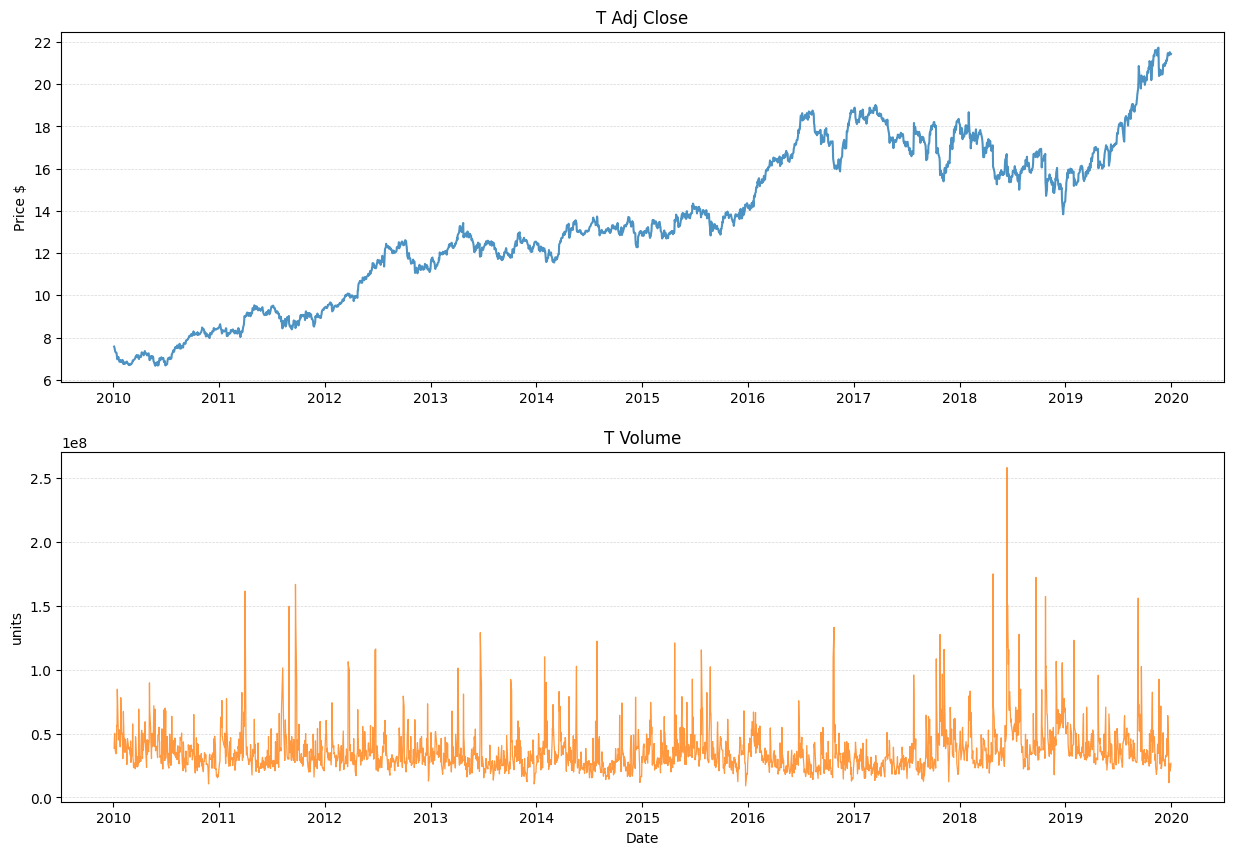

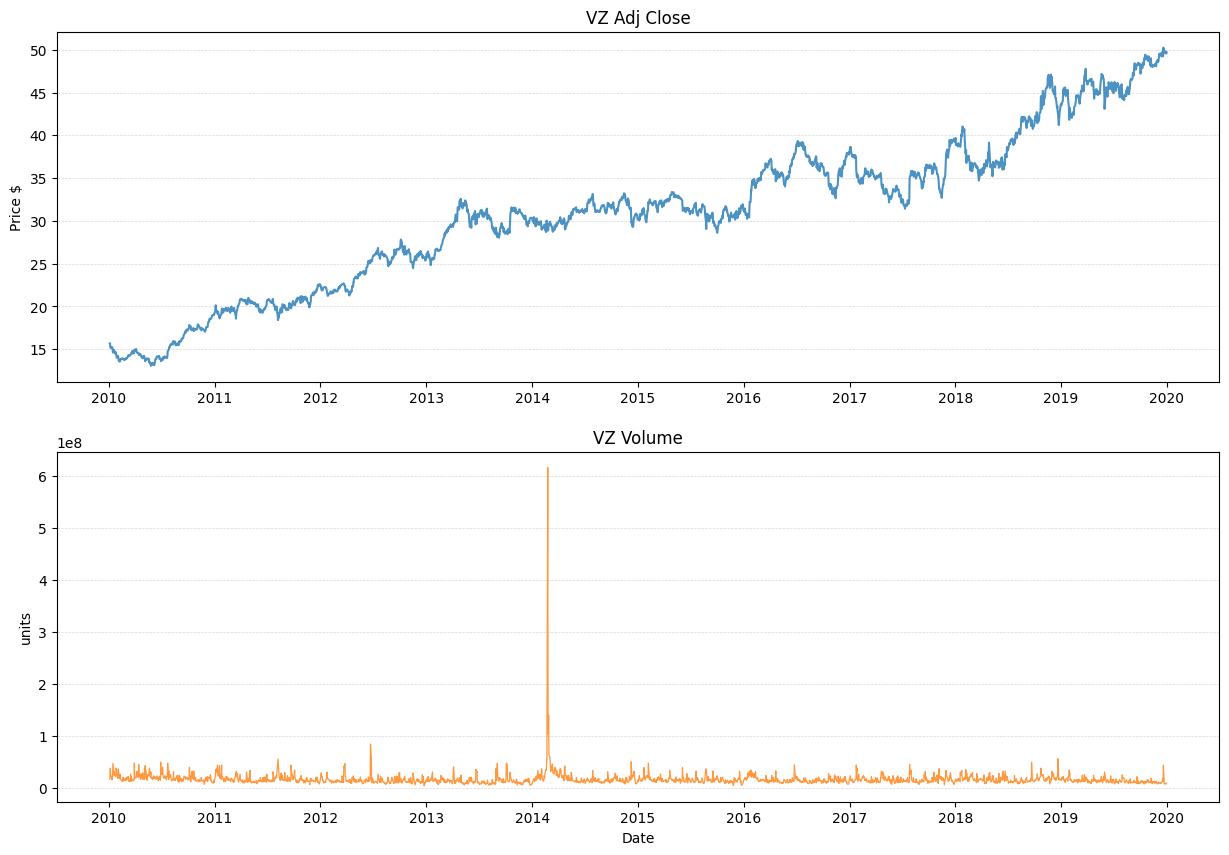

In [171]:
plot_adj_close_volume(data, ticker='T', y_log=False)
plot_adj_close_volume(data, ticker='VZ', y_log=False)

AT&T

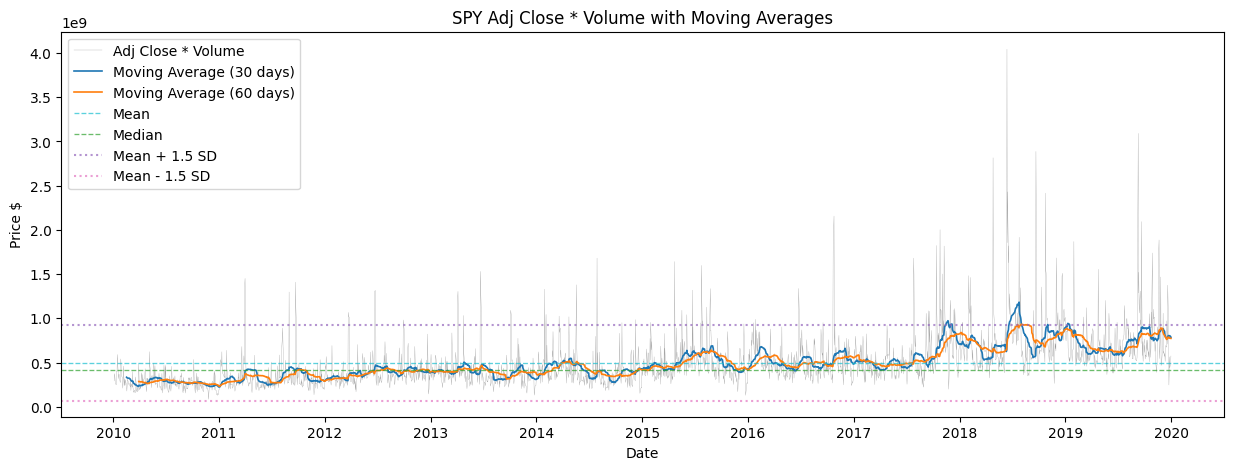

In [180]:
plot_moving_average(adj_close:=data[('Adj Close', 'T')],
                    volume:=data[('Volume', 'T')],
                    window_sizes=[30, 60], include_stats=True, log_scale=False)

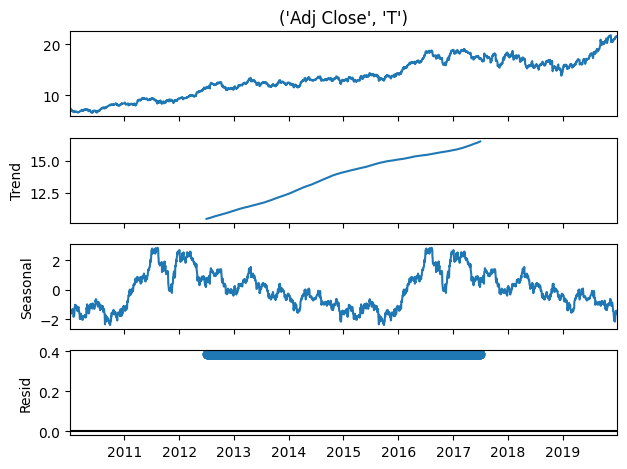

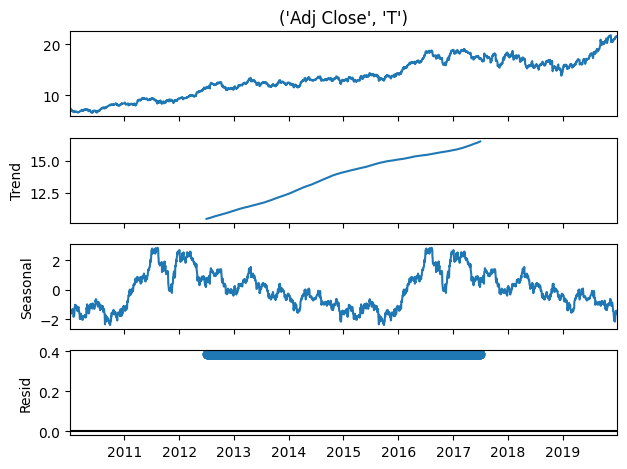

In [181]:
seasonal_decompose(
    adj_close, model='additive', period=len(data['Adj Close']) // 2
).plot()

Verizon

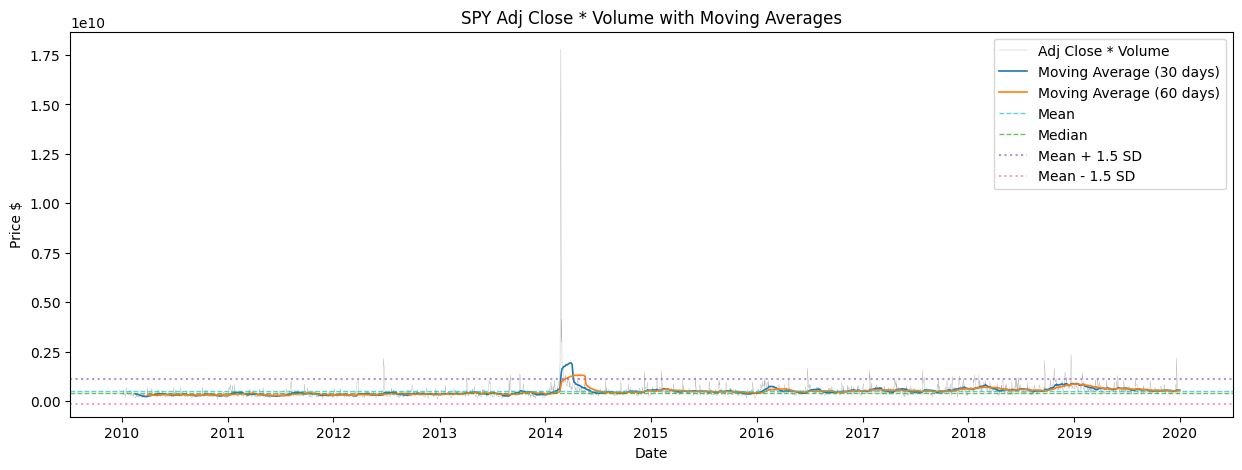

In [178]:
plot_moving_average(adj_close:=data[('Adj Close', 'VZ')],
                    volume:=data[('Volume', 'VZ')],
                    window_sizes=[30, 60], include_stats=True, log_scale=False)

There are some striking observation that I can get from this plot. One of them is the sudden drop occured in the mid of 2020. This corresponds to Covid-19 pandemic and therefore it makes sense to say that pandemic badly affected the stock prices in telecom industry as well as others. The other important observation is that stock price of Verizon exhibits a clear upward movement. However, even though a modest upward trend is visible during pre-Covid-19 era for AT&T, the stock price of this company has not revert back to its previous level.

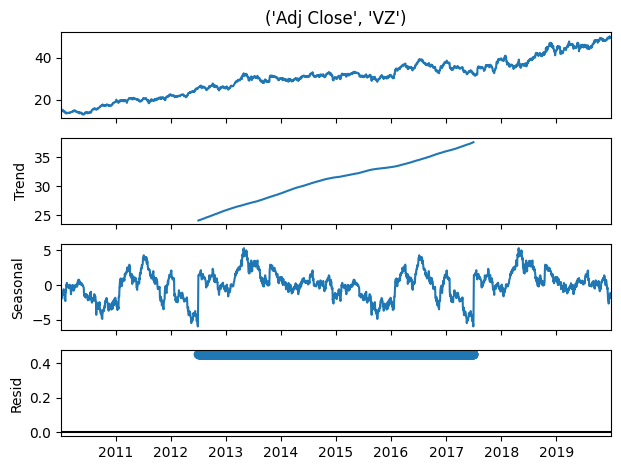

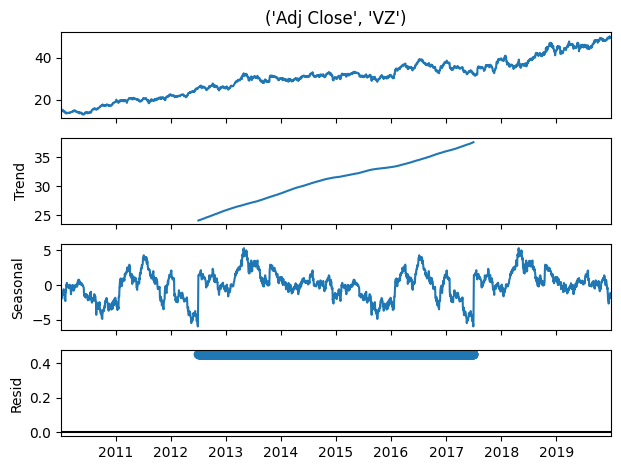

In [179]:
seasonal_decompose(
    adj_close, model='additive', period=len(data['Adj Close']) // 2
).plot()

Well, now we have three components of the time series. The first plot represents the behavior of raw data and the rest three plots exhibits the trend, seasonality, and residuals.

Let me briefly discuss the additive model with a period of 360. In time series, multiplicative model works well if the amplitude of both the seasonal and irregular variations increase as the level of the trend rises. Alternatively, additive model is suitable when the amplitude of both the seasonal and irregular variations do not change as the level of the trend rises or falls.

In `seasonal_decompose` library, we need to identify the period as long as we do not have timeseries index. Given the period of the data, the parameter period changes. For instance, if the data period is daily, then period becomes 360 and if the data period is monthly, the period takes the value of 12.

In [146]:
import cvxpy as cvx
import numpy as np

def optimize_twoasset_portfolio(varA, varB, rAB):
    """
    Optimize a two-asset portfolio to minimize portfolio variance.

    Parameters:
    varA (float): Variance of Stock A.
    varB (float): Variance of Stock B.
    rAB (float): Correlation between Stocks A and B.

    Returns:
    np.ndarray: Optimal weights [x_A, x_B] that minimize the portfolio variance.
    """
    # Calculate covariance
    cov = np.sqrt(varA) * np.sqrt(varB) * rAB

    # Define variables and covariance matrix
    x = cvx.Variable(2)
    P = np.array([[varA, cov], [cov, varB]])

    # Define objective and constraints
    objective = cvx.Minimize(cvx.quad_form(x, P))
    constraints = [sum(x) == 1]

    # Solve the optimization problem
    problem = cvx.Problem(objective, constraints)
    problem.solve()

    # Return the optimal weights as a numpy ndarray
    return np.array(x.value)


In [182]:
 """Test run optimize_twoasset_portfolio()."""
xA,xB = optimize_twoasset_portfolio(varA := data[('Adj Close', 'T')].var(),
                                    varB := data[('Adj Close', 'VZ')].var(),
                                    correlation:= data[('Adj Close', 'T')].corr(data[('Adj Close', 'VZ')]))
print("Weight on Stock A: {:.6f}".format(xA))
print("Weight on Stock B: {:.6f}".format(xB))

Weight on Stock A: 1.516628
Weight on Stock B: -0.516628
